# Práctica 1: Aprendizaje automático

__Fecha de entrega: 13 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 333

# Apartado 1: Clustering

__Número de grupo: 19__

__Nombres de los estudiantes: Alberto Sánchez Gómez y Sara Carpio Cuenca__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica.

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [2]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('prestamos.csv')
df['home_ownership_n'] = df['home_ownership_n'].astype('category')
df['emp_length_n'] = df['emp_length_n'].astype('category')
df['Default'] = df['Default'].astype('category')
df['purpose'] = df['purpose'].astype('category')
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


In [ ]:
df.dtypes

loan_amnt              int64
purpose             category
revenue              float64
dti_n                float64
fico_n               float64
home_ownership_n    category
emp_length_n        category
Default             category
dtype: object

Con el dataframe podemos observar que tenemos 13794 préstamos concedidos en total.

## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


Podemos ver que la desviación típica es muy alta en load_amnt y revenue, especialmente en revenue. Las otras dos también tienen una alta desviación, pero baja comparada con las otras dos.

En todas las variables podemos ver que el valor medio de cada una de ellas es más cercano al valor mínimo que al valor máximo. Por ejemplo en la variable revenue, el valor máximo está en 1650000 y el valor medio está en 79737.299507, por lo que podemos intuir que hay muchos con un valor bajo en esa variable. Esto también lo podemos comprobar con los percentiles de 75%, ya que en todos es un valor bajo comparado con el max (más cercano al valor min. que a max.)

In [ ]:
df.corr()

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000000,0.424460,0.034134,0.090869
revenue,0.424460,1.000000,-0.137616,0.091204
dti_n,0.034134,-0.137616,1.000000,-0.057580
fico_n,0.090869,0.091204,-0.057580,1.000000


Podemos ver, con los coeficientes de correlación, que las variables prácticamente no están relacionadas entre sí. El par de variables que mayor relación tienen son revenue y load_amnt, con una correlación positiva de 0.42. El resto no están casi relacionadas entre sí, ni positivamente ni negativamente.

Para estudiar las relaciones entre cada par de variables, en vez de sacar los gráficos uno a uno, vamos a usar una función de seaborn que nos devuelve una matriz con todas las gráficas de cada par de variables.

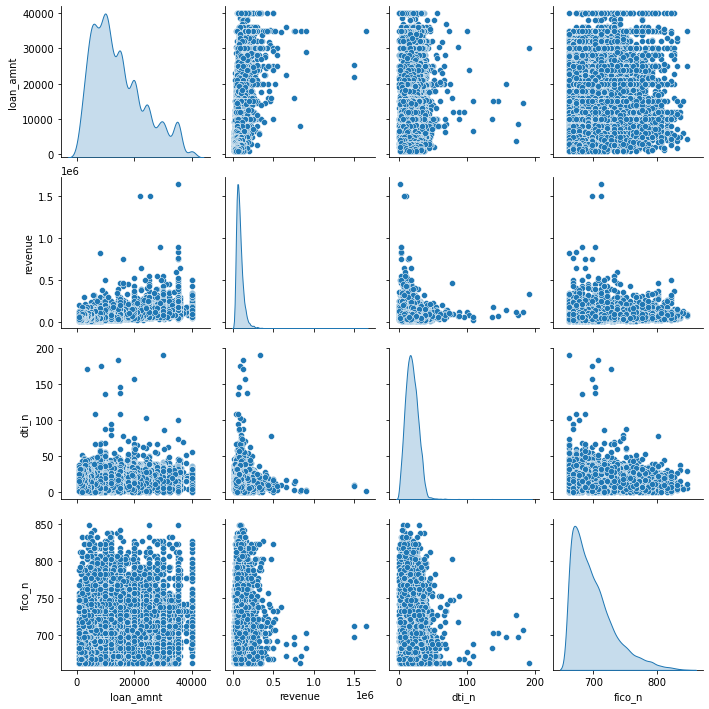

In [ ]:
import seaborn as sns

sns.pairplot(df, diag_kind = 'kde')

Como podíamos esperar, viendo las correlaciones de las variables, en los diagramas de dispersión no observamos ningún tipo de relación entre ellas.

En muchas de las parejas posibles, como con las variables (fico_n, dti_n) o (revenue, load_amnt), vemos que hay variables que tienen muchos elementos con valores bajos de esa variable. Por ejemplo, en el diagrama de loan_amnt y revenue, la gran mayoría de individuos del dataframe tienen un revenue bajo con respecto al resto, y además estos otros tienen un revenue demasiado alto, lo que hace que haya muchos puntos en la parte izquierda del gráfico.

En el caso de (fico_n, loan_amnt) vemos que los individuos no están tan "pegados" en el diagrama, debido a que los valores están repartidos más o menos de igual forma dentro del rango de esas variables, pero no existe ningún tipo de relación o "patrón" que podamos observar en la gráfica.

En el caso de (revenue, dti_n), podemos ver que hay muchos datos agrupados en la parte inferior izquierda del gráfico. Esto es porque en casi todos los casos cuando una variable toma valores bajos, la otra también, aunque tenemos algunos casos en los que una variable es muy alta y la otra muy baja (los puntos que se observan alejados del grupo)


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

In [ ]:
df.describe(include = ['category']).transpose()

,count,unique,top,freq
purpose,13794,12,debt_consolidation,7841
home_ownership_n,13794,4,MORTGAGE,6850
emp_length_n,13794,12,11,4612
Default,13794,2,0,10785


In [ ]:
df.groupby('purpose').describe()

loan_amnt                                               \
                       count          mean           std     min      25%   
purpose                                                                     
car                    154.0   8940.909091   6440.856377  1400.0  4356.25   
credit_card           2960.0  14750.582770   8719.990873  1000.0  8000.00   
debt_consolidation    7841.0  15331.969774   8865.044154  1000.0  8275.00   
home_improvement      1016.0  14352.436024   9623.463775  1000.0  6400.00   
house                   70.0  15540.714286  10231.562749  2500.0  7037.50   
major_purchase         337.0  11265.504451   9357.827863  1000.0  5000.00   
medical                163.0   9653.220859   7556.962260  1000.0  4100.00   
moving                 124.0   8313.104839   7037.344103  1000.0  3600.00   
other                  883.0  10883.550396   9000.683266  1000.0  4125.00   
renewable_energy        13.0  10682.692308   7911.603982  2000.0  3600.00   
small_business         145.0  17259.310345  10690.486078  1500.0  8225.00   
vacation                88.0   6160.227273   5877.989135  1000.0  2725.00   

                                              revenue                 ...  \
                        50%      75%      max   count           mean  ...   
purpose                                                               ...   
car                  7000.0  11200.0  32000.0   154.0   64769.422078  ...   
credit_card         12000.0  20000.0  40000.0  2960.0   80666.875838  ...   
debt_consolidation  14000.0  20000.0  40000.0  7841.0   78099.445168  ...   
home_improvement    12000.0  20000.0  40000.0  1016.0   96373.197559  ...   
house               12000.0  23800.0  40000.0    70.0   87978.194857  ...   
major_purchase       8400.0  15000.0  40000.0   337.0   76359.045104  ...   
medical              7225.0  13600.0  35000.0   163.0   74777.779141  ...   
moving               6000.0  10000.0  40000.0   124.0   77731.419355  ...   
other                8000.0  15000.0  40000.0   883.0   73975.084836  ...   
renewable_energy    10575.0  14500.0  28000.0    13.0   77693.076923  ...   
small_business      15000.0  24625.0  40000.0   145.0  101193.461310  ...   
vacation             4000.0   8000.0  30100.0    88.0   69692.500000  ...   

                      dti_n          fico_n                                \
                        75%     max   count        mean        std    min   
purpose                                                                     
car                 22.6050   38.66   154.0  706.191558  40.577095  662.0   
credit_card         24.7925  182.81  2960.0  698.567568  31.380464  662.0   
debt_consolidation  25.3000  174.86  7841.0  697.174212  31.117961  662.0   
home_improvement    22.8100  157.63  1016.0  706.857283  38.516893  662.0   
house               21.7875   32.98    70.0  709.357143  37.703279  662.0   
major_purchase      20.7100   37.32   337.0  709.833828  36.436045  662.0   
medical             25.1450   67.60   163.0  700.098160  34.606289  662.0   
moving              24.7800  108.67   124.0  697.282258  36.332377  662.0   
other               22.5400  190.87   883.0  700.833522  36.252274  662.0   
renewable_energy    25.0500   33.65    13.0  717.384615  51.090669  667.0   
small_business      20.9800   38.72   145.0  708.103448  39.173177  662.0   
vacation            25.6925   37.68    88.0  704.215909  37.222984  662.0   

                                                 
                      25%    50%     75%    max  
purpose                                          
car                 677.0  697.0  727.00  847.5  
credit_card         672.0  692.0  712.00  827.0  
debt_consolidation  672.0  687.0  712.00  847.5  
home_improvement    677.0  697.0  727.00  842.0  
house               677.0  702.0  735.75  797.0  
major_purchase      682.0  707.0  727.00  837.0  
medical             677.0  692.0  717.00  817.0  
moving              672.0  687.0  712.00  827.0  
o

In [ ]:
# Para que los gráficos nos aparezcan en los notebooks
%matplotlib inline

<AxesSubplot:>

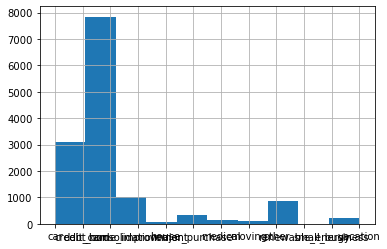

In [ ]:
df['purpose'].hist()

In [ ]:
df.groupby('emp_length_n').describe()

loan_amnt                                                      \
                 count          mean          std     min     25%      50%   
emp_length_n                                                                 
0                875.0  11534.857143  7534.712147  1000.0  6000.0  10000.0   
1               1174.0  14576.597104  9175.786487  1000.0  7500.0  12000.0   
2                909.0  13556.738174  8957.198263  1000.0  6500.0  11200.0   
3               1232.0  13876.968344  8885.973478  1000.0  7000.0  12000.0   
4               1174.0  14122.082624  8744.609806  1000.0  7025.0  12000.0   
5                815.0  14217.760736  9051.035753  1000.0  7000.0  12000.0   
6                860.0  14571.279070  8948.878504  1000.0  8000.0  12000.0   
7                580.0  14566.810345  8598.210552  1000.0  7800.0  12000.0   
8                470.0  14331.914894  9157.422395  1000.0  7000.0  12000.0   
9                599.0  14767.904841  9181.739899  1000.0  7200.0  12600.0   
10               494.0  14501.417004  8954.044720  1000.0  7550.0  12000.0   
11              4612.0  15525.390286  9277.337867  1000.0  8000.0  14000.0   

                                revenue                ...    dti_n          \
                   75%      max   count          mean  ...      75%     max   
emp_length_n                                           ...                    
0             15000.00  40000.0   875.0  53784.734103  ...  27.2500  174.86   
1             20000.00  40000.0  1174.0  81728.888007  ...  24.7975  190.87   
2             18000.00  40000.0   909.0  72649.554400  ...  23.9400   54.53   
3             19506.25  40000.0  1232.0  75690.260057  ...  23.6750   67.60   
4             20000.00  40000.0  1174.0  78169.293722  ...  24.1025  145.65   
5             20000.00  40000.0   815.0  79208.822945  ...  24.5800   87.85   
6             20000.00  40000.0   860.0  78503.368209  ...  23.8950  102.73   
7             20000.00  40000.0   580.0  81162.672293  ...  24.3825   62.70   
8             20000.00  40000.0   470.0  80403.481617  ...  25.0500   48.39   
9             20000.00  40000.0   599.0  83646.094725  ...  24.2250   47.89   
10            20000.00  40000.0   494.0  77907.222429  ...  24.2100   42.85   
11            21000.00  40000.0  4612.0  86795.989614  ...  25.0000  182.81   

              fico_n                                                      \
               count        mean        std    min    25%    50%     75%   
emp_length_n                                                               
0              875.0  701.137143  34.602574  662.0  672.0  692.0  717.00   
1             1174.0  698.328790  31.777775  662.0  672.0  692.0  712.00   
2              909.0  697.566557  31.895569  662.0  672.0  687.0  712.00   
3             1232.0  698.704951  32.317336  662.0  672.0  692.0  712.00   
4             1174.0  698.218058  32.358396  662.0  672.0  692.0  712.00   
5              815.0  697.993865  32.273497  662.0  672.0  692.0  712.00   
6              860.0  699.319767  32.050547  662.0  672.0  692.0  717.00   
7              580.0  696.862069  31.372985  662.0  672.0  687.0  712.00   
8              470.0  697.968085  31.465096  662.0  672.0  689.5  715.75   
9              599.0  697.751252  30.240450  662.0  672.0  692.0  717.00   
10             494.0  700.502024  35.446772  662.0  672.0  692.0  717.00   
11            4612.0  700.138768  33.723070  662.0  677.0  692.0  717.00   

                     
                max  
emp_length_n         
0             822.0  
1             822.0  
2             827.0  
3             847.5  
4             837.0  
5             832.0  
6             817.0  
7             822.0  
8             822.0  
9             842.0  
10            832.0  
11            847.5  

[12 rows x 32 columns]

<AxesSubplot:>

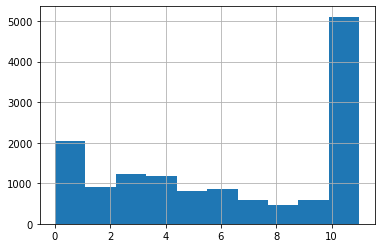

In [ ]:
df['emp_length_n'].hist()

<AxesSubplot:>

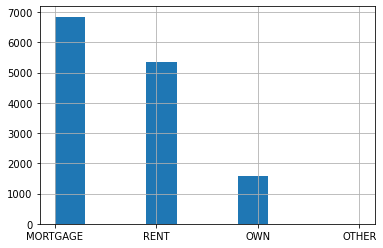

In [ ]:
df['home_ownership_n'].hist()

<AxesSubplot:>

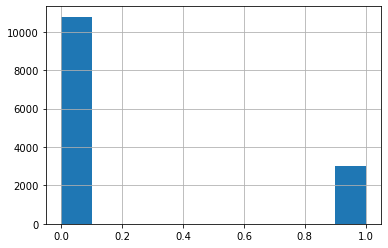

In [ ]:
df["Default"].hist()

In [ ]:
df.groupby('Default').describe()

loan_amnt                                                      \
            count          mean          std     min     25%      50%   
Default                                                                 
0         10785.0  14184.089013  9009.597893  1000.0  7000.0  12000.0   
1          3009.0  15668.212031  9045.576540  1000.0  8800.0  14000.0   

                           revenue                ...  dti_n           fico_n  \
             75%      max    count          mean  ...    75%     max    count   
Default                                           ...                           
0        20000.0  40000.0  10785.0  81105.847319  ...  23.90  190.87  10785.0   
1        21000.0  40000.0   3009.0  74832.085763  ...  26.92  157.63   3009.0   

                                                                   
               mean        std    min    25%    50%    75%    max  
Default                                                            
0        701.573621  34.020818  662.0  677.0  692.0  717.0  847.5  
1        690.265204  26.295834  662.0  672.0  682.0  702.0  827.0  

[2 rows x 32 columns]

En cuanto a la variable `purpose`, podemos ver que hay un valor que se repite mucho más en comparación con los demás, que es debit_consolidation.

En cuanto a la variable `emp_length_n`, podemos ver que más o menos todos los valores tienen la misma frecuencia, excepto el 0 y en mucha mayor medida el 11.

En cuanto a la variable `home_ownership_n`, podemos ver que el valor más frecuente es MORTGAGE, seguido en orden de RENT, OWN y OTHER (este sin ningún dato).

En cuanto a la variable `Default` vemos que en la gran mayoría de los casos sí pagaron el préstamo (10785 personas de las 13794)

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

In [ ]:
col_list = ['loan_amnt', 'revenue', 'dti_n', 'fico_n']
df_num = pd.read_csv('prestamos.csv', usecols = col_list)
df_num

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.0,18.93,687.0
1,32000,90000.0,9.29,822.0
2,30000,95000.0,1.34,722.0
3,25750,230000.0,6.42,747.0
4,25200,72000.0,30.95,692.0
...,...,...,...,...
13789,1275,42000.0,31.89,792.0
13790,1200,36000.0,12.27,747.0
13791,1000,76000.0,25.26,702.0
13792,1000,32000.0,17.70,747.0


Para ver si podemos usar el StandardScaler, tenemos que saber si la distribución de las variables es normal. Para verlo vamos a dibujar los gráficos de distribución de cada variable, aunque podríamos también mirar si coinciden la media, mediana y moda.

<AxesSubplot:ylabel='Density'>

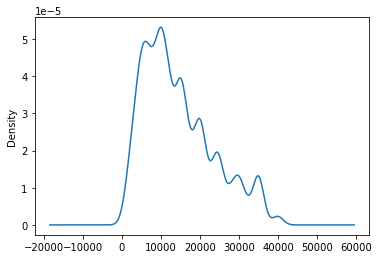

In [ ]:
df_num['loan_amnt'].plot(kind = 'density')

Ya con la variable `loan_amnt` podemos ver que no sigue una distribución normal, por lo tanto no podríamos usar el StandarScaler. Aun así, vamos a ver la gráfica del resto de variables.

<AxesSubplot:ylabel='Density'>

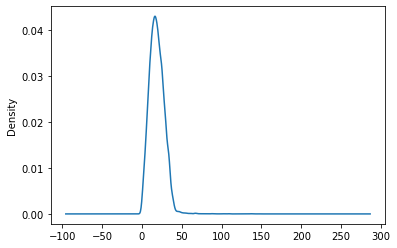

In [ ]:
df_num['dti_n'].plot(kind = 'density')

<AxesSubplot:ylabel='Density'>

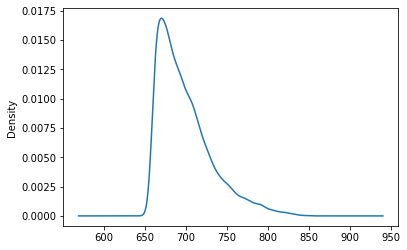

In [ ]:
df_num['fico_n'].plot(kind = 'density')

<AxesSubplot:ylabel='Density'>

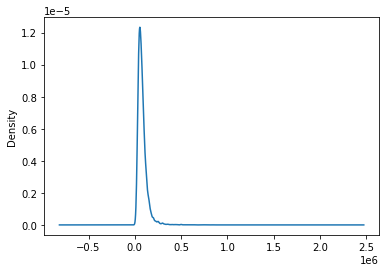

In [ ]:
df_num['revenue'].plot(kind = 'density')

Igual que lo que habíamos observado previamente, ninguna variable sigue estrictamente una distribución normal. Todas forman en cierta manera una campana, pero o no es uniforme, o está desplazada hacia un lado de la gráfica, por lo que no sigue plenamente esta distribución.

Por tanto, con esto podemos concluir que a priori, la mejor opción para el escalado de las variables sería el `MinMaxScaler`.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

df_num[col_list] = min_max_scaler.fit_transform(df_num[col_list])

df_num

,loan_amnt,revenue,dti_n,fico_n
0,0.794872,0.077906,0.099177,0.134771
1,0.794872,0.050517,0.048672,0.862534
2,0.743590,0.053561,0.007020,0.323450
3,0.634615,0.135727,0.033635,0.458221
4,0.620513,0.039562,0.162152,0.161725
...,...,...,...,...
13789,0.007051,0.021302,0.167077,0.700809
13790,0.005128,0.017651,0.064285,0.458221
13791,0.000000,0.041996,0.132341,0.215633
13792,0.000000,0.015216,0.092733,0.458221


## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo con la puntuación (con la función `KMeans.score()`), el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """

    colors = ['r','g','b','c','y','k','m',]
    fig = plt.figure(figsize=(8,8))

    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)

    plt.show()

In [ ]:
K_MAX = 11
davies_boulding = np.zeros(K_MAX-2)
k_score = np.zeros(K_MAX-2)
silhouette = np.zeros(K_MAX-2)
for k in range(2, K_MAX):
    km = KMeans(init='random', n_clusters=k, random_state=RANDOM_STATE)
    km.fit(df_num.values)

    davies_boulding[k-2] = davies_bouldin_score(df_num.values, km.labels_)
    k_score[k-2] = -km.score(df_num.values)
    silhouette[k-2] = silhouette_score(df_num.values, km.labels_)

In [ ]:
davies_boulding

array([0.96922137, 0.89979073, 0.91389745, 0.94923797, 0.97588478,
       0.93961964, 0.92664501, 0.94936224, 0.96555689])

In [ ]:
k_score

array([693.20721813, 482.80737599, 375.31626074, 317.63368034,
       274.09259137, 242.11056051, 213.79823464, 198.43288991,
       185.22043131])

In [ ]:
silhouette

array([0.4252408 , 0.40830854, 0.35755482, 0.34660247, 0.33369865,
       0.3261319 , 0.31154529, 0.3055641 , 0.29768139])

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

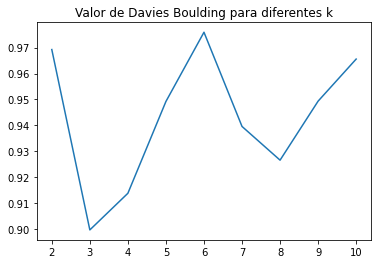

In [ ]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Text(0.5, 1.0, 'Valor de KMeans.score para diferentes k')

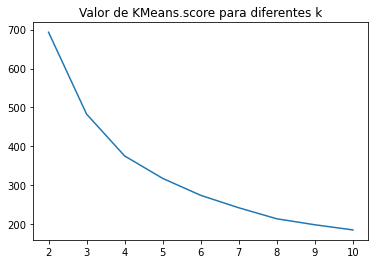

In [ ]:
plt.plot(range(2, K_MAX), k_score)
plt.title('Valor de KMeans.score para diferentes k')

Text(0.5, 1.0, 'Valor de Silhoutte para diferentes k')

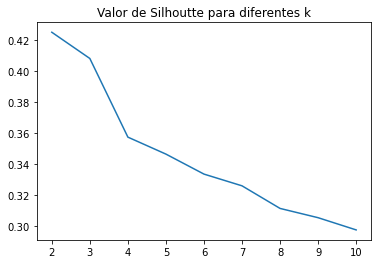

In [ ]:
plt.plot(range(2, K_MAX), silhouette)
plt.title('Valor de Silhoutte para diferentes k')

Sabemos que según Davies-Boulding, cuánto más pequeño es el valor mejor. Observando la gráfica, vemos que los valores más pequeños se alcanzan con 3 y 4 clusters. Debido a que la serie no es "monótona", no nos sale una gráfica uniforme, por lo que es dificil decir un "punto codo"

Sabemos que según el coeficiente de la silueta, cuánto mayor es mejor. Vemos que los mejores valores son 2 y 3. De igual manera es difícil observar un codo.

El KMeans.score() es el opuesto del objetivo del algoritmo (el objetivo es minimizar la distancia entre clusters e individuos). Por tanto, cuánto mayor es, mejor. Según la gráfica, el codo podríamos decir que está entre 4 o 5 clusters. Cuando hemos hecho el calculo del score para cada k, hemos multiplicado el valor por -1, para obtener una gráfica con forma de codo.

Debido a que con las tres métricas obtenemos resultados distintos, podemos ver que con el coeficiente de Davies y con el de la silueta, lo mejor estaría entre 2-4 clusters. Si añadimos la información del KMeans.score, una posibilidad es decir que el número óptimo de clusters sería 4.

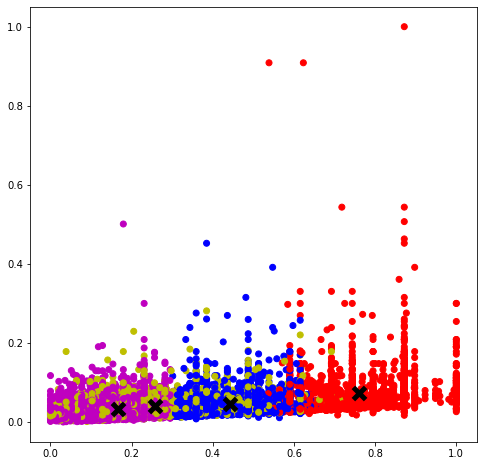

In [ ]:
# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=4, random_state=RANDOM_STATE)

# Agrupar los puntos en clusters
km.fit(df_num.values)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

plot_clusters(df_num.values, labels, centers)

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí.

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

In [ ]:
df_num2 = df_num.copy()
df_num2

,loan_amnt,revenue,dti_n,fico_n
0,0.794872,0.077906,0.099177,0.134771
1,0.794872,0.050517,0.048672,0.862534
2,0.743590,0.053561,0.007020,0.323450
3,0.634615,0.135727,0.033635,0.458221
4,0.620513,0.039562,0.162152,0.161725
...,...,...,...,...
13789,0.007051,0.021302,0.167077,0.700809
13790,0.005128,0.017651,0.064285,0.458221
13791,0.000000,0.041996,0.132341,0.215633
13792,0.000000,0.015216,0.092733,0.458221


Le añadimos la columna indicando a qué cluster pertence cada uno.

In [ ]:
df_num2[col_list] = min_max_scaler.inverse_transform(df_num2[col_list])
df_num2 = df_num2.assign(cluster=pd.Series(data=km.labels_))
df_num2

,loan_amnt,revenue,dti_n,fico_n,cluster
0,32000.0,135000.0,18.93,687.0,0
1,32000.0,90000.0,9.29,822.0,0
2,30000.0,95000.0,1.34,722.0,0
3,25750.0,230000.0,6.42,747.0,0
4,25200.0,72000.0,30.95,692.0,0
...,...,...,...,...,...
13789,1275.0,42000.0,31.89,792.0,2
13790,1200.0,36000.0,12.27,747.0,2
13791,1000.0,76000.0,25.26,702.0,3
13792,1000.0,32000.0,17.70,747.0,2


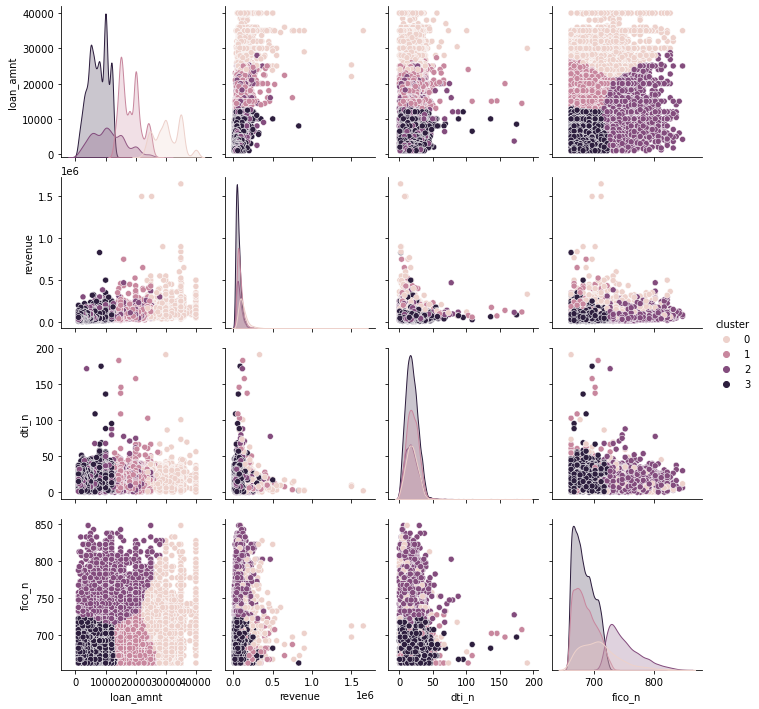

In [ ]:
sns.pairplot(df_num2, diag_kind ='kde', hue = 'cluster')

Podemos ver que los cluster que más se diferencian entre sí son el 0, 1 y 3.

Vemos que para loan_amnt y fico_n, los cluster no se solapan entre sí, podemos ver una región clara de cada color. Otros pares que también se separan bien son (loan_amnt, revenue) y (loan_amnt, dti_n).

Las variables que más se confunden son (revenue, fico_n) y (dti_n, fico_n). Vemos que los clusters están solapados entre sí y no podemos diferencias claramente quién pertence a cada cluster.

In [ ]:
df_num2.groupby(["cluster"]).describe().transpose()

cluster                     0              1              2              3
loan_amnt count  2.139000e+03    3646.000000    2299.000000    5710.000000
          mean   3.065531e+04   18226.439934   11078.088299    7465.363398
          std    4.375144e+03    3388.425639    5556.511367    3091.579915
          min    2.160000e+04   12750.000000    1000.000000    1000.000000
          25%    2.800000e+04   15000.000000    6400.000000    5000.000000
          50%    3.000000e+04   18000.000000   10000.000000    7500.000000
          75%    3.500000e+04   20000.000000   15000.000000   10000.000000
          max    4.000000e+04   27350.000000   28800.000000   13000.000000
revenue   count  2.139000e+03    3646.000000    2299.000000    5710.000000
          mean   1.280023e+05   83566.638859   74057.817960   61498.511333
          std    9.288931e+04   45232.695685   41232.341546   35394.304260
          min    3.500000e+04   20000.000000    9036.000000    7000.000000
          25%    8.200000e+04   55583.500000   46375.000000   39000.000000
          50%    1.050000e+05   73040.000000   65000.000000   54000.000000
          75%    1.450000e+05  100000.000000   90000.000000   75000.000000
          max    1.650000e+06  750001.000000  469000.000000  830000.000000
dti_n     count  2.139000e+03    3646.000000    2299.000000    5710.000000
          mean   1.883901e+01      19.921377      17.774711      18.542814
          std    9.902167e+00      10.053666      10.120095       9.384717
          min    2.200000e-01       0.220000       0.000000       0.000000
          25%    1.258500e+01      13.292500      10.530000      12.000000
          50%    1.836000e+01      19.260000      16.880000      17.770000
          75%    2.463500e+01      25.707500      23.745000      24.370000
          max    1.908700e+02     182.810000     171.390000     174.860000
fico_n    count  2.139000e+03    3646.000000    2299.000000    5710.000000
          mean   7.091391e+02     685.147285     750.493258     683.572680
          std    3.231646e+01      17.223695      26.659835      16.427398
          min    6.620000e+02     662.000000     717.000000     662.000000
          25%    6.870000e+02     672.000000     727.000000     667.000000
          50%    7.070000e+02     682.000000     742.000000     682.000000
          75%    7.270000e+02     697.000000     767.000000     697.000000
          max    8.475000e+02     732.000000     847.500000     722.000000

Según la cantidad de dinero del préstamo, el cluster 0 tiene una media muy superior a la de los otros dos clusters, lo que podría suponer una mayor probabilidad de Default. El cluster 3 la más baja.

Según la cantidad de ingresos anuales, los del cluster 0 también tienen una mayor cantidad de ingresos que el resto, por lo que podríamos pensar en un principio que en el cluster 0 no va a haber muchos Default. Los que menos tienen son los del cluster 3, por lo que podría indicar un número más alto de Default respecto a los otros clusters.

Según el porcentaje de endeudamiento, en general los datos son similares en todos los cluster, por lo que no podemos obtener mucha información de esta variable.

Según el indicador fico_n, el que más probabilidades tiene de devolver el préstamo es el cluster 0, ya que es el que tiene el valor medio más alto. Los que más tienen probabilidad de default son el 1 y el 3.

Con esta información, parece que los que van a tener una mayor tasa de Default son el 1 y el 3. Los préstamos del cluster 0 en general son los de más dinero, pero por lo que hemos observado en las otras variables, parece que se reduce la posibilidad de que sean Default.

Vamos a ver el número de Default por cada cluster, mirando en el dataframe original cuáles eran los que tenían el Default a 1.

In [ ]:
df_num2[df["Default"] == 1].groupby("cluster").describe()

loan_amnt                                                        \
            count          mean          std      min      25%      50%   
cluster                                                                   
0           497.0  31182.243461  4176.739345  21600.0  28000.0  30000.0   
1          1018.0  18527.455796  3507.547714  12800.0  15000.0  18000.0   
2           267.0  11532.490637  5197.049488   1150.0   7500.0  11200.0   
3          1227.0   7911.939690  3055.605369   1000.0   5312.5   8000.0   

                          revenue                 ...    dti_n          \
             75%      max   count           mean  ...      75%     max   
cluster                                           ...                    
0        35000.0  40000.0   497.0  120355.471107  ...  25.6200  100.60   
1        21000.0  26400.0  1018.0   76875.481071  ...  27.5275  157.63   
2        15000.0  25000.0   267.0   66244.297378  ...  28.5900   79.59   
3        10000.0  13000.0  1227.0   56566.104148  ...  26.3150  136.20   

         fico_n                                                            
          count        mean        std    min    25%    50%    75%    max  
cluster                                                                    
0         497.0  700.289738  30.564127  662.0  677.0  692.0  717.0  822.0  
1        1018.0  683.041257  16.476683  662.0  667.0  682.0  692.0  727.0  
2         267.0  741.625468  21.465355  717.0  727.0  737.0  752.0  827.0  
3        1227.0  681.022005  15.791422  662.0  667.0  677.0  692.0  722.0  

[4 rows x 32 columns]

Podemos ver que los clusters que más Default tienen a 1 son el cluster 1 y 3. Esto se ajusta a lo que habíamos observado antes. El cluster 0 es de los 3 observados el que menos Default tiene, aunque el 2 es el que menos tiene en total de los cuatro clusters.